In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\lrodr\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
tweets_test = pd.read_csv('./data/emoevales_test.tsv', sep='\t+')
test_gold = pd.read_csv('./data/emoevales_test_gold.tsv', sep='\t+')

C:\Users\lrodr\AppData\Local\Temp\ipykernel_24508\3242085986.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tweets_test = pd.read_csv('./data/emoevales_test.tsv', sep='\t+')
C:\Users\lrodr\AppData\Local\Temp\ipykernel_24508\3242085986.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_gold = pd.read_csv('./data/emoevales_test_gold.tsv', sep='\t+')


## XLM ROBERTA

In [3]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
model_path = "daveni/twitter-xlm-roberta-emotion-es"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
# PT
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [4]:
emotion_analysis = pipeline("text-classification", framework="pt", model=model_path, tokenizer=model_path)

In [5]:
predictions = []
for i in tqdm(range(len(tweets_test))):
    predictions.append(emotion_analysis(tweets_test.loc[i,'tweet'])[0]['label'])

  0%|          | 0/1656 [00:00<?, ?it/s]

100%|██████████| 1656/1656 [02:33<00:00, 10.76it/s]


In [6]:
labels = ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']
print(classification_report(y_true=test_gold['emotion'].values.tolist(), y_pred=predictions, labels=labels))

              precision    recall  f1-score   support

       anger       0.64      0.54      0.59       168
     disgust       0.00      0.00      0.00        33
        fear       1.00      0.05      0.09        21
         joy       0.66      0.66      0.66       354
      others       0.73      0.81      0.77       814
     sadness       0.66      0.81      0.73       199
    surprise       0.77      0.15      0.25        67

    accuracy                           0.70      1656
   macro avg       0.64      0.43      0.44      1656
weighted avg       0.69      0.70      0.68      1656



c:\Users\lrodr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lrodr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lrodr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


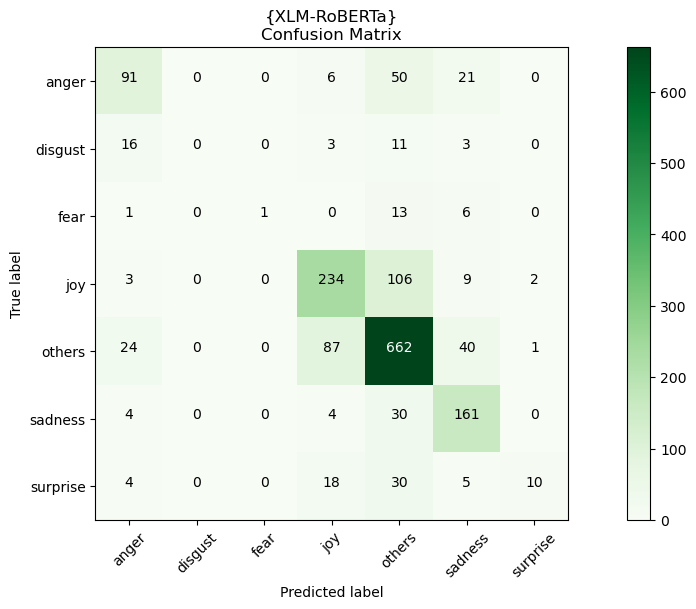

In [8]:
import matplotlib.pyplot as plt
import itertools
    
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  


# Calculamos la matriz de confusión
XLM = confusion_matrix(y_true=test_gold['emotion'].values.tolist(), y_pred=predictions, labels=labels) 


# Pintamos la matriz de confusión
plt.figure(figsize=(12, 6))
plot_confusion_matrix(XLM, classes=labels, title='{XLM-RoBERTa}\nConfusion Matrix')